# Single Particle in a Double Well

Let us start with the simplest Hamiltonian of one particle in a double well. The spin-statistics are irrelevant. The Hamiltonian is

\begin{equation}
H = p^2 + V_0 \left(-2x^2+x^4\right),
\end{equation}

This is a double well Hamiltonian, with minima at $x=\pm 1$ with magnitude $-V_0$ and local maximum at $x=0$ with magnitude $0$.

### Exact Quantum Dynamics
The exact dynamics is given by the Schrodinger equation

\begin{equation}
H|\psi(t)\rangle = i \frac{d}{dt}|\psi(t)\rangle,
\end{equation}

with the initial condition taken to be a Gaussian wavefunction localized at the minimum of the left well, *i.e.*

\begin{equation}
\langle x\vert \psi(0) \rangle = \frac{1}{\pi^{1/4}}\;e^{-\frac{1}{2}\left(x+1\right)^2}.
\end{equation}

This is the ground state of a Harmonic oscillator potential whose center is displaced from $x=0$ to $x=-1$, *i.e.*, the ground state of the Hamiltonian

\begin{equation}
H_{in} = p^2 + \left(x+1\right)^2.
\end{equation}

These formulae allow us to trivially code the exact dynamics in the Harmonic oscillator representation using QuTiP. The code is presented below. The observables that are plotted as functions of time are

\begin{align}
\bar{x} &\equiv \langle x \rangle \\
\sigma_x &\equiv \sqrt{\langle x^2 \rangle  - \langle x \rangle^2} \\
\bar{p} &\equiv \langle p \rangle \\
\sigma_p &\equiv \sqrt{\langle p^2 \rangle  - \langle p \rangle^2} \\
\end{align}

In [36]:
import numpy as np
from qutip import destroy, mesolve
from qutip.ui import EnhancedTextProgressBar as pb

#Level of the harmonic oscillator at which we choose to truncate our problem
N = 50
V = 1.0

a = destroy(N)

x = (a.dag() + a)
p = (1j) * (a.dag() - a)

H = p**2 + V * (-2 * x**2 + x**4)

en, psi_0 = (p**2 + (x + 1)**2).groundstate()
t = np.linspace(0.0, 4.0, 1000)
exact_dynamics_sp = mesolve(H,psi_0,t,[],[x, x**2, p, p**2], progress_bar=pb()) 


 Total run time:  10.47s*] Elapsed 10.47s / Remaining 00:00:00:00*         3%           ] Elapsed 0.41s / Remaining 00:00:00:13[****     17%           ] Elapsed 1.82s / Remaining 00:00:00:08[******** 36%           ] Elapsed 3.78s / Remaining 00:00:00:06[*********69%****       ] Elapsed 7.28s / Remaining 00:00:00:03[*********75%*****      ] Elapsed 7.86s / Remaining 00:00:00:02[*********84%*******    ] Elapsed 8.82s / Remaining 00:00:00:01


### Truncated Wigner Dynamics


...Write...

In [42]:
import numpy as np
from odeintw import odeintw
from numpy.random import multivariate_normal
from qutip import parallel_map
from qutip.ui import EnhancedTextProgressBar as pb

nsamples = 20
V = 1.0
times = np.linspace(0.0, 4.0, 1000)


def rhs_dtwa_bbgky_sp(psi, t):
    """
    psi1, psi2, tau1, tau2, chi = (x, p, x^2, p^2, xp)_Weyl
    """
    psi1, psi2, tau1, tau2, chi = psi
    dpsi1dt = 2 * psi2
    dpsi2dt = -4 * V * psi1 * (tau1 - 1)
    dtau1dt = 2 * (2 * chi -(1j))
    dtau2dt = 4 * V * (2* chi - (1j)) * (1-tau1)
    dchidt = 2 * tau2 + 4 * V * tau1 * (1 - tau1)
    
    return np.array([dpsi1dt, dpsi2dt, dtau1dt, dtau2dt, dchidt])


def wigner_function(x, p):
    return 2.0 * np.exp(-(x+1)**2 + p**2)
    
def run_dtwa_bbgky(seed):
    np.random.seed(seed)
    x, p = multivariate_normal(np.array([-1, 0]), np.array([[0.5, 0],[0, 0.5]]))
    psi_0 = np.array([x, p, x**2, p**2, x* p], dtype='complex128')
    return odeintw(rhs_dtwa_bbgky_sp, psi_0, times)
    

twa_result = parallel_map(run_dtwa_bbgky, np.arange(nsamples),progress_bar=pb())
twa_result = np.array(twa_result)

 Total run time:   0.31s*] Elapsed 0.27s / Remaining 00:00:00:00


### Plots for Single Particle in a Double Well

(1000,) (1000,)


/home/daneel/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/daneel/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/daneel/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/daneel/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


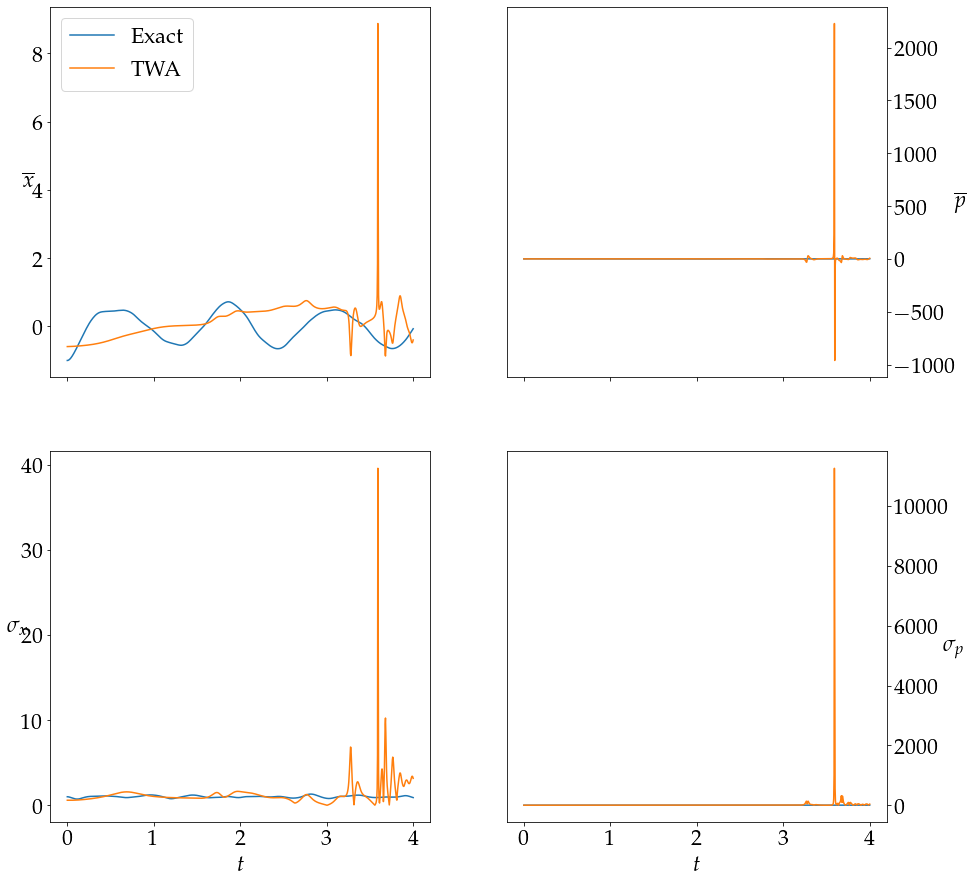

In [43]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size" : 22,
    "figure.figsize" : (15,15)
})

xbar_exact, xsqbar_exact, pbar_exact, psqbar_exact = exact_dynamics_sp.expect

xbar_twa = np.average(twa_result[:,:,0], axis=0)
pbar_twa = np.average(twa_result[:,:,1], axis=0)
xsqbar_twa = np.average(twa_result[:,:,2], axis=0)
psqbar_twa = np.average(twa_result[:,:,3], axis=0)

print(xbar_exact.shape, xbar_twa.shape)

f, axs = plt.subplots(2, 2, sharex=True)

axs[0,0].plot(t,xbar_exact, label='Exact')
axs[0,0].plot(times,xbar_twa, label='TWA')
axs[0,0].legend()
axs[0,0].set_ylabel(r"$\overline{x}$", rotation=0)

axs[0,1].plot(t,pbar_exact)
axs[0,1].plot(times,pbar_twa)
axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
axs[0,1].set_ylabel(r"$\overline{p}$", rotation=0)


axs[1,0].plot(t,np.sqrt(xsqbar_exact-xbar_exact**2))
axs[1,0].plot(t,np.sqrt(xsqbar_twa-xbar_twa**2))
axs[1,0].set_xlabel(r"$t$", rotation=0)
axs[1,0].set_ylabel(r"$\sigma_{x}$", rotation=0)

axs[1,1].plot(t,np.sqrt(psqbar_exact-pbar_exact**2))
axs[1,1].plot(t,np.sqrt(psqbar_twa-pbar_twa**2))
axs[1,1].set_xlabel(r"$t$", rotation=0)
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()
axs[1,1].set_ylabel(r"$\sigma_{p}$", rotation=0)

plt.show()

# Two Fermions in three wells

The simplest interacting system where spin-statistics starts to matter is that of $2$ fermions in three wells. The Hamiltonian, in full operator form in the Hilbert Space spanned by both particles,  is 

\begin{equation}
H = \left(p_1\otimes \mathbb{1}\right)^2 + \left(\mathbb{1} \otimes p_2\right)^2 + V\left(x_1\otimes \mathbb{1}\right) + V\left(\mathbb{1} \otimes x_2\right) + U\left(x_1\otimes \mathbb{1} - \mathbb{1}\otimes x_2\right).
\end{equation}

Here the three wells are represented by the potential

\begin{equation}
V(x) = x^2 - \beta \left(x^4-\frac{x^6}{6}\right),
\end{equation}

which has three minima at  $\xi_0, \xi_{1,-1}=0, \pm\sqrt{2}\left(1+\sqrt{1-\displaystyle\frac{1}{2\beta}}\right)^{1/2}$. In addition, we have introduced a Gaussian interaction between the two fermions, given by

\begin{equation}
U(x) = U_0 e^{-x^2/s^2}.
\end{equation}

### Exact Quantum Dynamics
The exact dynamics is given by the Schrodinger equation

\begin{equation}
H|\psi(t)\rangle = i \frac{d}{dt}|\psi(t)\rangle,
\end{equation}

with the initial condition taken to be a antisymmetric direct product of Gaussian wavefunctions localized at the central and rightmost minima, *i.e.*,

\begin{equation}
\vert\psi(0) \rangle = \frac{1}{\sqrt{2}}\left[\vert\phi_0\rangle\otimes\vert\phi_{-1}\rangle-\vert\phi_{-1}\rangle\otimes\vert\phi_{0}\rangle\right],
\end{equation}
where $\phi_{-1,0}$ is the ground state of a harmonic oscillator whose potential is centered around $\xi_{-1, 0}$ respectively. Therefore, $\phi_{-1,0}$ are the ground states of
\begin{equation}
H^{\pm}_{in} = p^2 + \left(x-\xi_{-1,0}\right)^2
\end{equation}
respectively, with
\begin{align}
\langle x\vert\phi_{-1}\rangle &= \frac{1}{\pi^{1/4}}e^{-\frac{1}{2}\left(x-\xi_{-1}\right)^2},\\
\langle x\vert\phi_{0}\rangle &= \frac{1}{\pi^{1/4}}e^{-\frac{1}{2}\left(x-\xi_{0}\right)^2},\\
\end{align}

These formulae allow us to code the exact dynamics in the Harmonic oscillator representation using QuTiP. The code is presented below. The observables that are plotted as functions of time (for now) are

\begin{align}
\bar{x}_1 &\equiv \langle x_1\otimes\mathbb{1} \rangle \\
\bar{x}_2 &\equiv \langle \mathbb{1}\otimes x_2 \rangle \\
\bar{p}_1 &\equiv \langle p_1\otimes\mathbb{1} \rangle \\
\bar{p}_2 &\equiv \langle \mathbb{1}\otimes p_2 \rangle 
\end{align}

In [7]:
import numpy as np
from qutip import identity, destroy, mesolve
from qutip.tensor import tensor
from qutip.ui import EnhancedTextProgressBar as pb

#Level of the harmonic oscillator at which we choose to truncate our problem
N = 10
b = 0.7
u0 = 20.0
s = 0.1

a = destroy(N)
one = identity(N)

x = (a.dag() + a)
p = (1j) * (a.dag() - a)

x1 = tensor(x, one)
p1 = tensor(p, one)
x2 = tensor(one, x)
p2 = tensor(one, p)

H = p1**2 +  x1**2 - b*(x1**4 - x1**6/6)\
            + p2**2 - x2**2 - b*(x2**4 - x2**6/6)\
                        + u0 * (-(x1-x2)*(x1-x2)/s**2).expm() 

xim1 = np.sqrt(2 * (1 + np.sqrt(1-(1/(2*b)))))
enm1, phim1 = (p**2 + (x-xim1)**2).groundstate()

x10, phi0 = (p**2 + x**2).groundstate()

xi1 = - xim1
en1, phi1 = (p**2 + (x-xi1)**2).groundstate()

psi_0 = (tensor(phi0,phim1) - tensor(phim1,phi0))/np.sqrt(2)
t = np.linspace(0.0, 8.0, 2000)

exact_dynamics_2p = mesolve(H,psi_0,t,[],[x1, x2, p1, p2], progress_bar=pb())

 Total run time:   8.53s*] Elapsed 8.53s / Remaining 00:00:00:00[******** 36%           ] Elapsed 3.13s / Remaining 00:00:00:05


### Fermionic Truncated Wigner Dynamics for two particles


...Write

### Plots for exact vs FTWA for two particles

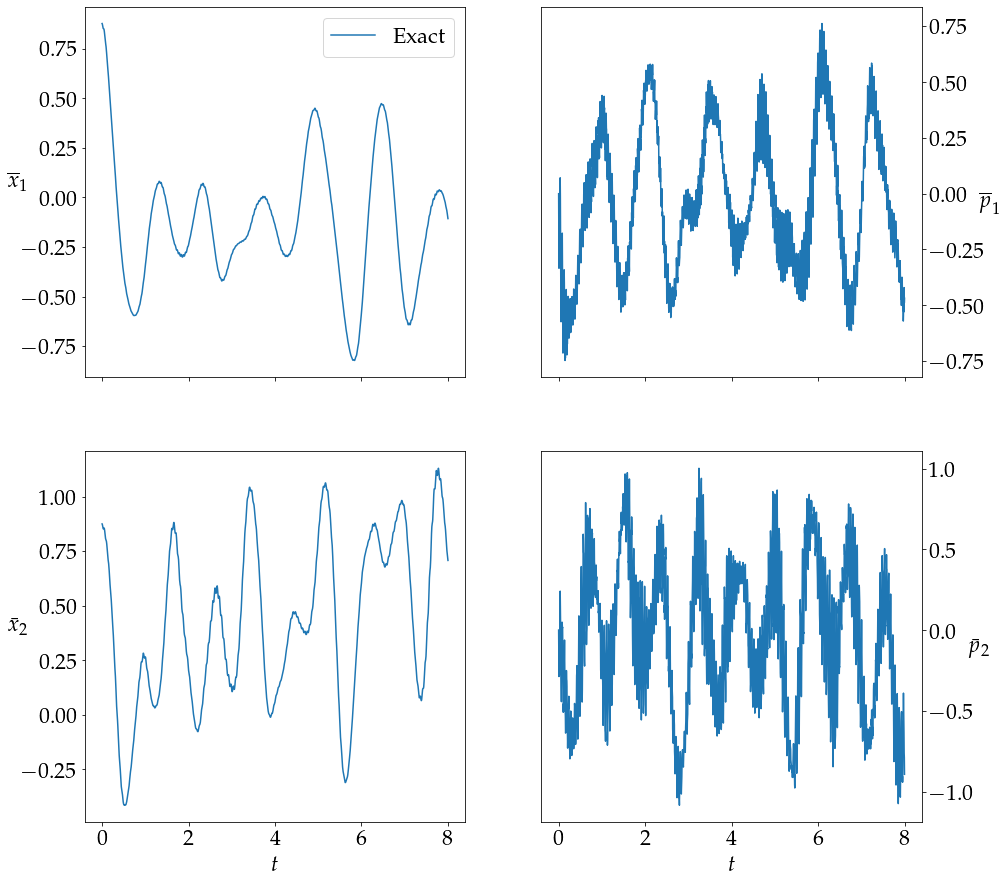

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size" : 22,
    "figure.figsize" : (15,15)
})

x1bar, x2bar, p1bar, p2bar = exact_dynamics_2p.expect
f, axs = plt.subplots(2, 2, sharex=True)

axs[0,0].plot(t,x1bar, label='Exact')
axs[0,0].legend()
axs[0,0].set_ylabel(r"$\overline{x}_1$", rotation=0)

axs[0,1].plot(t,p1bar)
axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
axs[0,1].set_ylabel(r"$\overline{p}_1$", rotation=0)


axs[1,0].plot(t,x2bar)
axs[1,0].set_xlabel(r"$t$", rotation=0)
axs[1,0].set_ylabel(r"$\bar{x}_2$", rotation=0)

axs[1,1].plot(t,p2bar)
axs[1,1].set_xlabel(r"$t$", rotation=0)
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()
axs[1,1].set_ylabel(r"$\bar{p}_2$", rotation=0)

plt.show()